In [2]:
import torch
import torch_geometric
from torch_geometric.data import Data
import networkx as nx

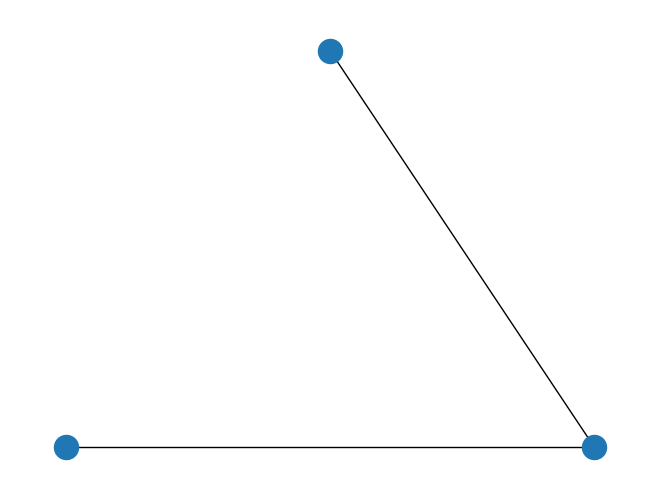

In [3]:
edge_index = torch.tensor([
  [0, 1, 1, 2],
  [1, 0, 2, 1]
], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)
g = torch_geometric.utils.to_networkx(data, to_undirected=True)
nx.draw(g, pos=nx.planar_layout(g))

In [24]:
data

Data(x=[3, 1], edge_index=[2, 4])

In [25]:
data.validate(raise_on_error=True)

True

In [26]:
print(data.keys)

['edge_index', 'x']


In [27]:
print(data['x'])

tensor([[-1.],
        [ 0.],
        [ 1.]])


In [34]:
print(data.num_nodes)
print(data.num_edges)
print(data.num_node_features)
print(data.has_isolated_nodes())
print(data.has_self_loops())
data.is_directed()

3
4
1
False
False


False

In [35]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')


Extracting /tmp/ENZYMES/ENZYMES/ENZYMES.zip
Processing...
Done!


In [39]:
print(len(dataset))
print(dataset.num_classes)
print(dataset.num_node_features)

600
6
3


In [40]:
data = dataset[0]

In [41]:
data

Data(edge_index=[2, 168], x=[37, 3], y=[1])

In [42]:
data.is_undirected()

True

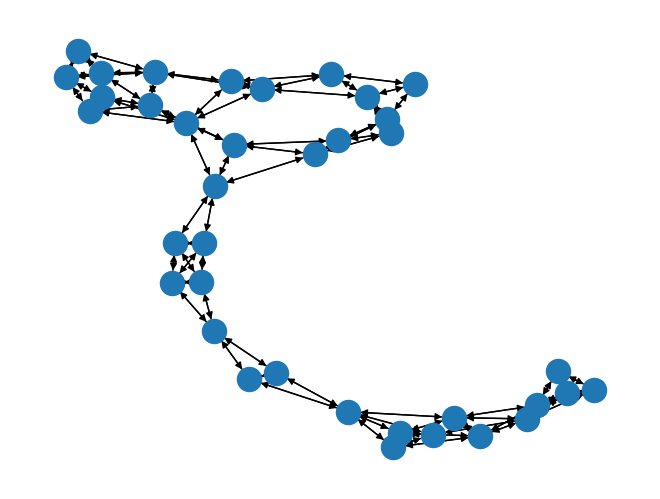

In [51]:
g = torch_geometric.utils.to_networkx(data)
nx.draw(g)

In [54]:
train_dataset = dataset[:540].shuffle()
train_dataset

ENZYMES(540)

In [57]:
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES', use_node_attr=True)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

for batch in loader:
  print(batch.num_graphs)


32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
24


In [59]:
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root='/tmp/Cora', name='Cora')


Processing...
Done!


In [60]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
  def __init__(self) -> None:
    super().__init__()
    self.conv1 = GCNConv(dataset.num_node_features, 16)
    self.conv2 = GCNConv(16, dataset.num_classes)

  def forward(self, data):
    x, edge_index = data.x, data.edge_index

    x = self.conv1(x, edge_index)
    x = F.relu(x)
    x = F.dropout(x, training=self.training)
    x = self.conv2(x, edge_index)

    return F.log_softmax(x, dim=1)

In [62]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
model.train()

for epoch in range(200):
  optimizer.zero_grad()
  out = model(data)
  loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
  loss.backward()
  optimizer.step()

In [63]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')


Accuracy: 0.8050


# Обучение GCN

In [5]:
import torch
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree 

In [6]:
from typing import Any, Dict, List, Optional, Union
from torch import Tensor


from torch_geometric.nn.aggr import Aggregation


class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr="add")
        self.lin = Linear(in_channels, out_channels, bias=False)
        self.bias = Parameter(torch.empty(out_channels))
        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_()

    def forward(self, x, edge_index) -> Any:
        # Add self loops
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(x, x.size(0),dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        out = self.propagate(edge_index, x=x, norm=norm)

        # Step 6: Apply a final bias vector.
        out += self.bias

        return out
    
    def message(self, x_j: Tensor, norm) -> Tensor:
        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j 